In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Objectives

Course4U grows rapidly and reaches millions of learners in a very short period. The learning topics of AI Training Room can be summarized in the following word cloud:
​
<center>
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_1/images/word_cloud.png" width="600" alt="word cloud">
<center>

Starting this year, machine learning engineer team is working very hard on a recommender system project. **The main goal of this project is to improve learners’ learning experience via helping them quickly find new interested courses and better paving their learning paths**. Meanwhile, **with more learners interacting with more courses via C4U recommender systems,C4U company’s revenue may also be increased**.

This project is currently at the *Proof of Concept (PoC) phase* so your **main focus at this moment is to explore and compare various machine learning models and find one with the best performance in off-line evaluations.**

In <a href="https://www.kaggle.com/code/wahyuardhitama/task003-p001-ml-dl-rec-sys-course-20231025">part 1 (P01)</a>, we elaborate on a content-based recommender system using unsupervised learning, where we utilize user profiles and course genres. In <a href="https://www.kaggle.com/code/wahyuardhitama/task003-p002-ml-dl-rec-sys-course-20231029">part 2 (P02)</a>, we explore clustering-based recommender system using unsupervised learning. Finally, in the last part,part 3 (P03)</a>, we take a deep dive into a content-based recommender system using supervised learning.

### Note: 
This project's dataset was created for pedagogical purposes and may not represent real-world data. The project consists of multiple notebook parts, focusing on combining data from various tables and conducting data analysis and prediction to acquire valuable insights.

## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li><a href="#Import">Import the relevant libraries</a></li>
    <li><a href="#Coll_Fil">Collaborative Filtering based Recommender System using K Nearest Neighbor</a></li>
    <ul>
        <li><a href="#Opt_1">Implementation Option 1: Use Surprise library (recommended)</a></li>
    </ul>
    <li><a href="#Coll_NMF">Collaborative Filtering based Recommender System using Non-negative Matrix Factorization</a></li>
    <ul>
        <li><a href="#Opt_2">Implementation Option 1: Use Surprise library (recommended)</a></li>
    </ul>
    <li><a href="#Coll_NN">Course Rating Prediction using Neural Networks</a></li>
    <ul>
        <li><a href="#Opt_3">TASK (Optional): Customize the RecommenderNet to potentially improve the model performance</a></li>
    </ul>
    <li><a href="#Reg_Bas">Regression-based Rating Score Prediction using Embedding Features</a></li>
    <li><a href="#Cls_Bas">Classification-based Rating Score Prediction using Embedding Features</a></li>
</ol>

<img style="float:left" src="https://i.imgur.com/gIne5bH.png" width="80">

<h1><a id="Import">Import the Relevant Libraries</a></h1>

In [2]:
# also set a random state
rs = 123

In [3]:
## Preprocessing
### Load the data
ratings_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/ratings.csv"
#course_df = pd.read_csv(course_genre_url)
ratings_df = pd.read_csv(ratings_url)
ratings_df

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0
...,...,...,...
233301,1540125,DS0101EN,3.0
233302,1250651,PY0101EN,3.0
233303,1003832,CB0105ENv1,3.0
233304,922065,BD0141EN,3.0


<img style="float:left" src="https://i.imgur.com/rb8V6X5.png" width="50">

# Explarotary Data Analysis (EDA)

<h1><a id="Coll_Fil">Collaborative Filtering based Recommender System using K Nearest Neighbor</a></h1>

In [4]:
ratings_df.head()

,user,item,rating
0,1889878,CC0101EN,3.0
1,1342067,CL0101EN,3.0
2,1990814,ML0120ENv3,3.0
3,380098,BD0211EN,3.0
4,779563,DS0101EN,3.0


Note that this matrix is presented as the dense or vertical form, and you may convert it to a sparse matrix using `pivot` :

In [5]:
rating_sparse_df = ratings_df.pivot(index='user', columns='item', values='rating').fillna(0).reset_index().rename_axis(index=None, columns=None)
rating_sparse_df.head()

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,0.0,3.0,0.0,0.0,3.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,3.0,0.0,2.0,2.0,0.0,3.0,0.0
1,4,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0
2,5,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Perform KNN-based collaborative filtering on the user-item interaction matrix. 
You may choose one of the two following implementation options of KNN-based collaborative filtering. 
- The first one is to use `scikit-surprise` which is a popular and easy-to-use Python recommendation system library. 
- The second way is to implement it with standard `numpy`, `pandas`, and `sklearn`. You may need to write a lot of low-level implementation code along the way.

<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h3><a id="Opt_1">Implementation Option 1: Use <b>Surprise</b> library (recommended)</a>

One-stop Suprise solution: Suprise is a Python library specifically designed for building and analyzing recommender systems. It provides a high-level interface for implementing various recommendation algorithms, including KNN, with minimal coding effort. Using the "one-stop Suprise solution" means utilizing Suprise library's built-in functions and classes to implement the KNN model without delving deeply into the underlying algorithms or implementations.

In [6]:
pip show scikit-surprise

Name: scikit-surprise
Version: 1.1.3
Summary: An easy-to-use library for recommender systems.
Home-page: https://surpriselib.com
Author: Nicolas Hug
Author-email: contact@nicolas-hug.com
License: GPLv3+
Location: /opt/conda/lib/python3.10/site-packages
Requires: joblib, numpy, scipy
Required-by: 
Note: you may need to restart the kernel to use updated packages.


Now we import required classes and methods

In [7]:
from surprise import KNNBasic
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

In [8]:
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

Perform KNN collaborative filtering on a sample movie review dataset, which contains about 100k movie ratings from users.

In [9]:
# Load the movielens-100k dataset (download it if needed),
data = Dataset.load_builtin('ml-100k', prompt=False)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data, test_size=.25)

# We'll use the famous KNNBasic algorithm.
knn_bas = KNNBasic()

# Train the algorithm on the trainset, and predict ratings for the testset
knn_bas.fit(trainset)
predictions_knn_1 = knn_bas.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_knn_1)

Trying to download dataset from https://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9839


0.9838726995705963

As you can see, just a couple of lines and you can apply KNN collaborative filtering on the sample movie lens dataset. The main evaluation metric is `Root Mean Square Error (RMSE)` which is a very popular rating estimation error metric used in recommender systems as well as many regression model evaluations.

The choice between using KNN Basic for classification or regression depends on the specific problem and the type of data being analyzed. For example, KNN Basic can be applied to classification tasks such as predicting customer churn (where the target variable is binary) or regression tasks such as predicting house prices (where the target variable is continuous).

#### Our dataset

In [10]:
ratings_df.to_csv("course_ratings.csv", index=False)
# Read the course rating dataset with columns user item rating
reader = Reader(
        line_format='user item rating', sep=',', skip_lines=1, rating_scale=(2, 3))

course_dataset = Dataset.load_from_file("course_ratings.csv", reader=reader)

In [11]:
course_dataset

In [12]:
trainset, testset = train_test_split(course_dataset, test_size=.3)

In [13]:
print(f"Total {trainset.n_users} users and {trainset.n_items} items in the trainingset")

Total 31341 users and 123 items in the trainingset


In [14]:
knn_bas = KNNBasic()

# Train the algorithm on the trainset, and predict ratings for the testset
knn_bas.fit(trainset)
predictions_knn_2 = knn_bas.test(testset)

# Then compute RMSE
accuracy.rmse(predictions_knn_2)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.1947


0.19474525881515184

<div class="alert alert-block alert-info">
<img style="float: left" src="https://i.imgur.com/HVpiyd6.png[/img" width="60">
<b style = "font-family: Arial; font-size: 16px">Results:</b><p style = "font-family:Verdana; font-size:14px">

<ol>
    <li><b>Magnitude of Error:</b>The first scenario has a higher RMSE (0.9836), indicating larger prediction errors, while the second scenario has a lower RMSE (0.1949), indicating smaller prediction errors.
    <li><b>Model Performance:</b>The second scenario provide better predictions or recommendations.
    <li><b>Precision:</b>The second scenario reflects higher precision in predicting ratings or constructing a similarity matrix..
</ol>
</div>

In [15]:
# Compute MAE, MSE, RMSE
mae_knn = accuracy.mae(predictions_knn_2)
mse_knn = accuracy.mse(predictions_knn_2)
rmse_knn = accuracy.rmse(predictions_knn_2)

MAE:  0.0418
MSE: 0.0379
RMSE: 0.1947


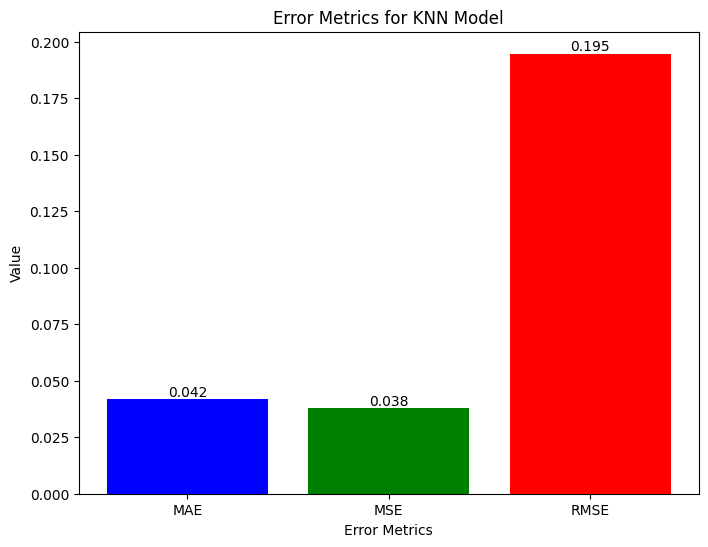

In [16]:
import matplotlib.pyplot as plt

# List of error metrics
error_metrics = ['MAE', 'MSE', 'RMSE']

# Corresponding values
error_values = [mae_knn, mse_knn, rmse_knn]

# Plotting the graph
plt.figure(figsize=(8, 6))
#plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])
bars = plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Error Metrics for KNN Model')

# Adding y-values on the bars
for bar, value in zip(bars, error_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3), 
             ha='center', va='bottom', color='black')

# Save the figure
plt.savefig('01_knn_error_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()

These metrics are more appropriate for evaluating the performance of regression models predicting continuous values like ratings.

In [17]:
# Display prediction results
for prediction in predictions_knn_2[:15]:  # Displaying the first 15 predictions as an example
    print(f"User {prediction.uid} rated Item {prediction.iid} with a true rating of {prediction.r_ui} and predicted rating of {prediction.est}")

User 1775524 rated Item BD0115EN with a true rating of 3.0 and predicted rating of 3
User 1352222 rated Item DS0103EN with a true rating of 3.0 and predicted rating of 3
User 1246282 rated Item DS0103EN with a true rating of 3.0 and predicted rating of 3
User 1451848 rated Item CC0201EN with a true rating of 3.0 and predicted rating of 3
User 1437361 rated Item DV0101EN with a true rating of 3.0 and predicted rating of 3
User 322129 rated Item DS0103EN with a true rating of 3.0 and predicted rating of 3
User 669512 rated Item PY0101EN with a true rating of 3.0 and predicted rating of 3
User 2034749 rated Item ST0101EN with a true rating of 3.0 and predicted rating of 3
User 1999572 rated Item DS0105EN with a true rating of 3.0 and predicted rating of 3
User 1036546 rated Item BD0211EN with a true rating of 3.0 and predicted rating of 3
User 1006881 rated Item RP0103EN with a true rating of 3.0 and predicted rating of 3
User 345793 rated Item ML0101EN with a true rating of 3.0 and predi

In [18]:
# Define target users
target_users = [1078030, 733707, 674939,2057052]

# Display predictions for the specified users
for user_id in target_users:
    user_predictions = [pred for pred in predictions_knn_2 if pred.uid == str(user_id)]
    
    print(f"\nPredictions for User {user_id}:")
    for prediction in user_predictions:
        print(f"Item {prediction.iid}: Predicted Rating = {prediction.est}")


Predictions for User 1078030:
Item ML0120ENv2: Predicted Rating = 3
Item ML0101ENv3: Predicted Rating = 3

Predictions for User 733707:
Item RP0103: Predicted Rating = 3
Item ML0151EN: Predicted Rating = 3
Item BD0101EN: Predicted Rating = 3
Item BD0135EN: Predicted Rating = 3
Item DS0101EN: Predicted Rating = 3
Item SC0105EN: Predicted Rating = 3
Item ST0101EN: Predicted Rating = 3
Item BD0111EN: Predicted Rating = 3
Item BD0141EN: Predicted Rating = 3
Item BD0131EN: Predicted Rating = 3
Item BD0212EN: Predicted Rating = 3

Predictions for User 674939:
Item BD0121EN: Predicted Rating = 3
Item BD0115EN: Predicted Rating = 3
Item BD0211EN: Predicted Rating = 3
Item BD0212EN: Predicted Rating = 3
Item BD0145EN: Predicted Rating = 3

Predictions for User 2057052:


In [19]:
# Define target users
target_users = [1078030, 733707, 674939, 2057052]

# Initialize a list to store the results
results_list = []

# Display predictions for the specified users
for user_id in target_users:
    user_predictions = [pred for pred in predictions_knn_2 if pred.uid == str(user_id)]
    
    for prediction in user_predictions:
        item_id = prediction.iid
        predicted_rating = prediction.est
        
        # Append the result to the list
        results_list.append({
            'User': user_id,
            'Item': item_id,
            'Predicted Rating': predicted_rating
        })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results_list)

results_df

,User,Item,Predicted Rating
0,1078030,ML0120ENv2,3
1,1078030,ML0101ENv3,3
2,733707,RP0103,3
3,733707,ML0151EN,3
4,733707,BD0101EN,3
5,733707,BD0135EN,3
6,733707,DS0101EN,3
7,733707,SC0105EN,3
8,733707,ST0101EN,3
9,733707,BD0111EN,3


In [20]:
## Preprocessing
### Load the data
course_genre_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_genre.csv"

In [21]:
course_df = pd.read_csv(course_genre_url)
course_df

,COURSE_ID,TITLE,Database,Python,CloudComputing,DataAnalysis,Containers,MachineLearning,ComputerVision,DataScience,BigData,Chatbot,R,BackendDev,FrontendDev,Blockchain
0,ML0201EN,robots are coming build iot apps with watson ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
1,ML0122EN,accelerating deep learning with gpu,0,1,0,0,0,1,0,1,0,0,0,0,0,0
2,GPXX0ZG0EN,consuming restful services using the reactive ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
3,RP0105EN,analyzing big data in r using apache spark,1,0,0,1,0,0,0,0,1,0,1,0,0,0
4,GPXX0Z2PEN,containerizing packaging and running a sprin...,0,0,0,0,1,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
302,excourse89,javascript jquery and json,0,0,0,0,0,0,0,0,0,0,0,1,1,0
303,excourse90,programming foundations with javascript html ...,0,0,0,0,0,0,0,0,0,0,0,1,1,0
304,excourse91,front end web development with react,0,0,0,0,0,0,0,0,0,0,0,0,1,0
305,excourse92,introduction to web development,0,0,0,0,0,0,0,0,0,0,0,1,1,0


In [22]:
rec_merge_df = pd.merge(results_df, course_df[['COURSE_ID','TITLE']], how='left', left_on='Item', right_on='COURSE_ID')
# Drop unnecessary columns
rec_merge_df = rec_merge_df.drop(['COURSE_ID'], axis=1)
rec_merge_df

,User,Item,Predicted Rating,TITLE
0,1078030,ML0120ENv2,3,deep learning with tensorflow
1,1078030,ML0101ENv3,3,machine learning with python
2,733707,RP0103,3,using r with databases
3,733707,ML0151EN,3,machine learning with r
4,733707,BD0101EN,3,big data 101
5,733707,BD0135EN,3,developing distributed applications using zook...
6,733707,DS0101EN,3,introduction to data science
7,733707,SC0105EN,3,data science with scala
8,733707,ST0101EN,3,statistics 101
9,733707,BD0111EN,3,hadoop 101


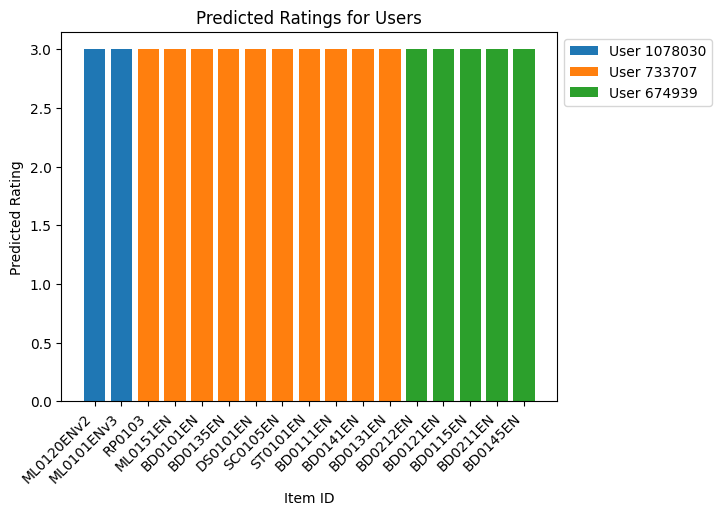

In [23]:
from matplotlib import pyplot as plt
# Function to get predicted ratings for a user
def get_user_predictions(predictions_knn_2, user_id):
    return [(pred.iid, pred.est) for pred in predictions_knn_2 if pred.uid == str(user_id)]

# Define target users
target_users = [1078030, 733707, 674939, 2057052]

# Display predictions in a bar chart
for user_id in target_users:
    user_predictions = get_user_predictions(predictions_knn_2, user_id)
    
    # Check if there are predictions for the user
    if user_predictions:
        # Separate item IDs and predicted ratings
        item_ids, predicted_ratings = zip(*user_predictions)
        
        # Create a bar chart
        plt.bar(item_ids, predicted_ratings, label=f'User {user_id}')

# Add labels and legend
plt.xlabel('Item ID')
plt.ylabel('Predicted Rating')
plt.title('Predicted Ratings for Users')

# Rotate x-labels by 45 degrees
plt.xticks(rotation=45, ha='right')
# Set legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the plot to a file (choose the format you prefer, e.g., PNG, PDF, SVG)
plt.savefig('02_predicted_ratings_plot_knn.png', bbox_inches='tight')

# Show the plot
plt.show()

We do not compute ROC AUC since the regression task is not suitable for ROC curve analysis due to the nature of the problem. Instead, we focus on evaluating the model using classification metrics suitable for the binary classification approach applied to the regression problem.

## Implementation Option 2: Use `numpy`, `pandas`, and `sklearn`
If you do not prefer the one-stop Suprise solution and want more hardcore coding practices, you may implement the KNN model using `numpy`, `pandas`, and possibly `sklearn`:

More hardcore coding practices: This implies a preference for implementing the KNN model from scratch using lower-level libraries such as NumPy and pandas for data manipulation, and possibly using scikit-learn for additional functionality like data preprocessing or evaluation metrics. This approach involves a deeper understanding of the algorithm and requires more manual coding compared to using high-level libraries like Suprise.

### KNN Classification
If we used KNN classification, consider the prediction problem as a classification problem as rating only has two categorical values (`Aduit` vs. `Completion`).

In [24]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

accuracy_list = []
recall_list = []
precision_list = []
f1_score_list = []
#auc = []

# Initialize KNNBasic algorithm
#knn_bas = KNNBasic()

# Train the algorithm on the trainset
#knn_bas.fit(trainset)

# Predict ratings for the testset
#predictions_knn_2 = knn_bas.test(testset)

# Convert predictions to binary labels using a threshold (e.g., 3)
threshold = 3
y_true = [1 if pred.r_ui >= threshold else 0 for pred in predictions_knn_2]
y_pred = [1 if pred.est >= threshold else 0 for pred in predictions_knn_2]

# Compute Accuracy
accuracy = accuracy_score(y_true, y_pred)
accuracy_list.append(accuracy)

# Compute Precision
precision = precision_score(y_true, y_pred)  # Requires labels for binary classification
precision_list.append(precision)

# Compute Recall
recall = recall_score(y_true, y_pred)  # Requires labels for binary classification
recall_list.append(recall)

# Compute F1-Score
f1 = f1_score(y_true, y_pred)
f1_score_list.append(f1)

# Compute AUC (ROC curve is not meaningful for regression, but we can compute AUC for the precision-recall curve)
#auc = roc_auc_score(y_true, y_pred)

print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1-Score: {f1}")
#print(f"AUC: {auc}")

# Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_score_list,
})    
metrics_df

Accuracy: 0.9580094867984913
Precision: 0.9984209374316
Recall: 0.957450636441326
F1-Score: 0.9775066775855076


,Accuracy,Precision,Recall,F1-Score
0,0.958009,0.998421,0.957451,0.977507


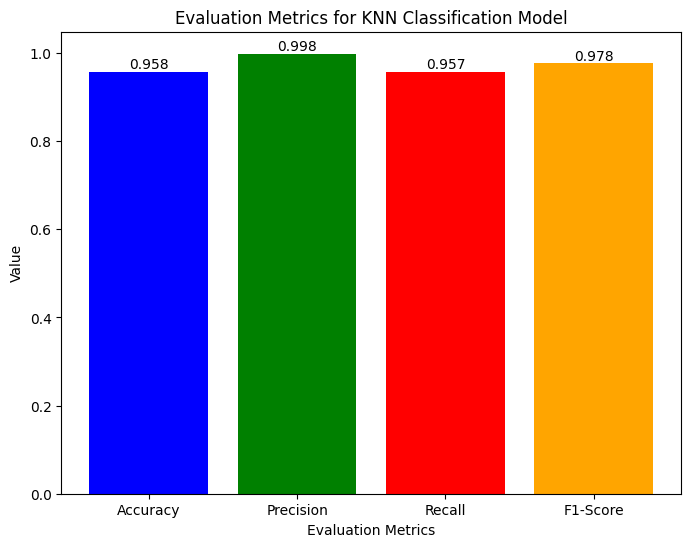

In [25]:
# List of evaluation metrics
eva_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Corresponding values
eva_values = [accuracy, precision, recall, f1]

# Plotting the graph
plt.figure(figsize=(8, 6))
bars = plt.bar(eva_metrics, eva_values, color=['blue', 'green', 'red', 'orange'])

# Adding labels and title
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Evaluation Metrics for KNN Classification Model')

# Adding y-values on the bars
for bar, value in zip(bars, eva_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3), 
             ha='center', va='bottom', color='black')

# Save the figure
plt.savefig('03_knn_clf_evaluation_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()

In [26]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Compute MAE, MSE, RMSE
mae_knn_clf = mean_absolute_error(y_true, y_pred)
mse_knn_clf = mean_squared_error(y_true, y_pred)
rmse_knn_clf = np.sqrt(mse_knn_clf)

print(f"MAE: {mae_knn_clf}")
print(f"MSE: {mse_knn_clf}")
print(f"RMSE: {rmse_knn_clf}")

MAE: 0.04199051320150874
MSE: 0.04199051320150874
RMSE: 0.20491586859369565


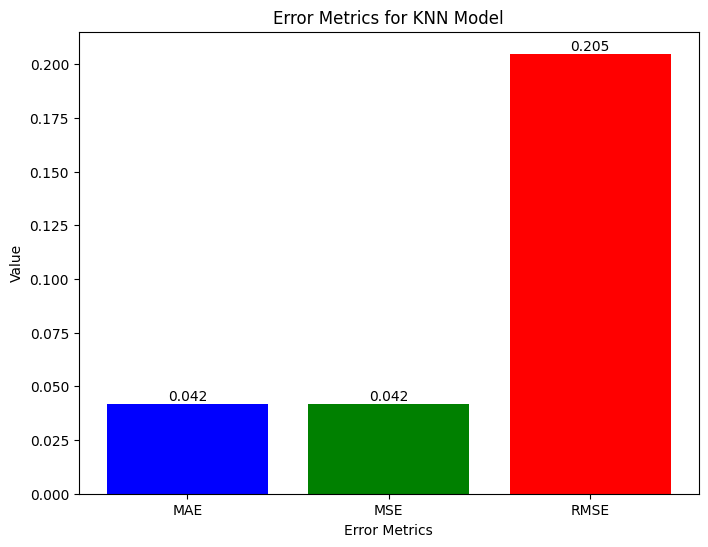

In [27]:
# List of error metrics
error_metrics = ['MAE', 'MSE', 'RMSE']

# Corresponding values
error_values = [mae_knn_clf, mse_knn_clf, rmse_knn_clf]

# Plotting the graph
plt.figure(figsize=(8, 6))
#plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])
bars = plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Error Metrics for KNN Model')

# Adding y-values on the bars
for bar, value in zip(bars, error_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3), 
             ha='center', va='bottom', color='black')

# Save the figure
plt.savefig('04_knn_clf_error_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()

In classification, we use metrics like accuracy, precision, recall, and F1-score to evaluate the performance of the model in predicting categorical labels.
In regression, we use metrics like MAE, MSE, and RMSE to evaluate the performance of the model in predicting continuous values.

<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Execute</h1></div>

# Summary
We learned and implemented K Nearest Neighbor (KNN)-based collaborative filtering. It is probably the simplest but very effective and intuitive collaborative filtering algorithm. Since it is based on KNN, <b>it inherits the main characteristics of KNN such as memory-intensive because you need to maintain a huge similarity matrix among users or items</b>. In the future labs, we will learn other types of <b>collaborative filtering which do not rely on such a huge similarity matrix to make rating predictions.</b>
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The KNN-based collaborative filtering results
    <li>Personalized recommendations by considering the preferences of similar users or items.
    <li>The similarity between users or items, using a straightforward nearest-neighbor approach.
    <li>New users or items based on the preferences of similar entities. Similar users or items are used to infer preferences for new entities.
    <li>Relies on the local neighborhood of users or items, and it can find meaningful connections.    
</ol>


<h1><a id="Coll_NMF">Collaborative Filtering based Recommender System using Non-negative Matrix Factorization</a>

### TASK: Perform NMF-based collaborative filtering on the course-interaction matrix


In [28]:
from surprise import NMF
from surprise import Dataset, Reader
from surprise.model_selection import train_test_split
from surprise import accuracy

The dataset (ratings_df) contains three columns, `user id`, `item id`, and `the rating`. Note that this matrix is presented as the dense or vertical form, you may convert it using `pivot` to the original sparse matrix:


In [29]:
rating_sparse_df = ratings_df.pivot(index='user', columns='item', values='rating').fillna(0).reset_index().rename_axis(index=None, columns=None)
rating_sparse_df.head()

,user,AI0111EN,BC0101EN,BC0201EN,BC0202EN,BD0101EN,BD0111EN,BD0115EN,BD0121EN,BD0123EN,...,SW0201EN,TA0105,TA0105EN,TA0106EN,TMP0101EN,TMP0105EN,TMP0106,TMP107,WA0101EN,WA0103EN
0,2,0.0,3.0,0.0,0.0,3.0,2.0,0.0,2.0,2.0,...,0.0,2.0,0.0,3.0,0.0,2.0,2.0,0.0,3.0,0.0
1,4,0.0,0.0,0.0,0.0,2.0,2.0,2.0,2.0,2.0,...,0.0,2.0,0.0,0.0,0.0,2.0,2.0,0.0,2.0,2.0
2,5,2.0,2.0,2.0,0.0,2.0,0.0,0.0,0.0,2.0,...,0.0,0.0,2.0,2.0,2.0,2.0,2.0,2.0,0.0,2.0
3,7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,8,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


ext, you need to implement NMF-based collaborative filtering, and you may choose one of the two following implementation options: 
- The first one is to use `Surprise` which is a popular and easy-to-use Python recommendation system library. 
- The second way is to implement it with `numpy`, `pandas`, and `sklearn`. You may need to write a lot of low-level implementation code along the way.


<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h3><a id="Opt_2">Implementation Option 1: Use <b>Surprise></b> library (recommended)</a>


In [30]:
## WRITE YOUR CODE HERE:


# - Define a NMF model NMF(verbose=True, random_state=123)

# - Train the NMF on the trainset, and predict ratings for the testset

# - Then compute RMSE

# more NMF model hyperparamets can be found here:

# https://surprise.readthedocs.io/en/stable/matrix_factorization.html

# You may try different hyperparamet combinations to see which one has the best performance
# - Define a NMF model NMF(verbose=True, random_state=123)
nmf = NMF(verbose=True, random_state=123)

# - Train the NMF on the trainset, and predict ratings for the testset
nmf.fit(trainset)

# Predict ratings for the testset
predictions_nmf_1 = nmf.test(testset)

# - Then compute RMSE
accuracy.rmse(predictions_nmf_1)

Processing epoch 0
Processing epoch 1
Processing epoch 2
Processing epoch 3
Processing epoch 4
Processing epoch 5
Processing epoch 6
Processing epoch 7
Processing epoch 8
Processing epoch 9
Processing epoch 10
Processing epoch 11
Processing epoch 12
Processing epoch 13
Processing epoch 14
Processing epoch 15
Processing epoch 16
Processing epoch 17
Processing epoch 18
Processing epoch 19
Processing epoch 20
Processing epoch 21
Processing epoch 22
Processing epoch 23
Processing epoch 24
Processing epoch 25
Processing epoch 26
Processing epoch 27
Processing epoch 28
Processing epoch 29
Processing epoch 30
Processing epoch 31
Processing epoch 32
Processing epoch 33
Processing epoch 34
Processing epoch 35
Processing epoch 36
Processing epoch 37
Processing epoch 38
Processing epoch 39
Processing epoch 40
Processing epoch 41
Processing epoch 42
Processing epoch 43
Processing epoch 44
Processing epoch 45
Processing epoch 46
Processing epoch 47
Processing epoch 48
Processing epoch 49
RMSE: 0.20

0.206456424429477

In [31]:
# Compute MAE, MSE, RMSE
mae_nmf = accuracy.mae(predictions_nmf_1)
mse_nmf = accuracy.mse(predictions_nmf_1)
rmse_nmf = accuracy.rmse(predictions_nmf_1)

MAE:  0.0859
MSE: 0.0426
RMSE: 0.2065


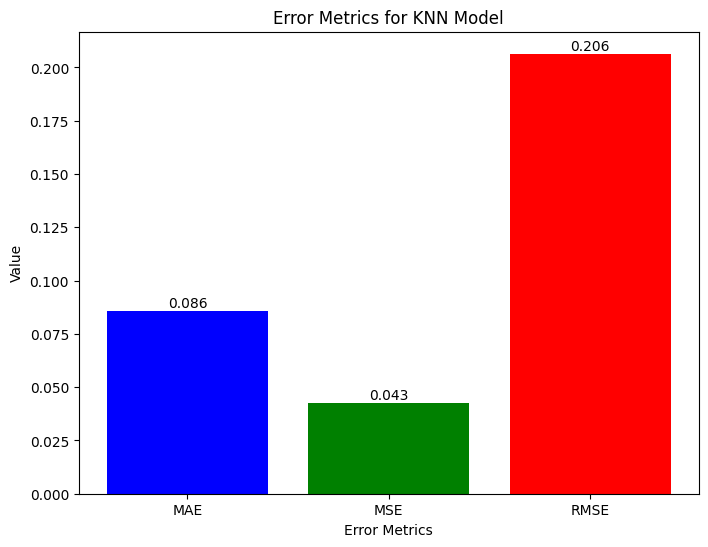

In [32]:
# List of error metrics
error_metrics = ['MAE', 'MSE', 'RMSE']

# Corresponding values
error_values = [mae_nmf, mse_nmf, rmse_nmf]

# Plotting the graph
plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Error Metrics for KNN Model')

# Adding y-values on the bars
for bar, value in zip(bars, error_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3),
             ha='center', va='bottom', color='black')  # Fixing the 'va' parameter

# Save the figure
plt.savefig('05_nmf_error_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()

In [33]:
# Define target users
target_users = [1078030, 733707, 674939, 2057052]

# Create an empty list to store prediction data
prediction_data = []

# Extract predictions for the specified users
for user_id in target_users:
    user_predictions = [(str(user_id), str(pred.iid), pred.est) for pred in predictions_nmf_1 if pred.uid == str(user_id)]
    
    # Extend the prediction_data list with user predictions
    prediction_data.extend(user_predictions)

# Create a DataFrame from the prediction data
columns = ['User', 'Item', 'Predicted_Rating']
predictions_df = pd.DataFrame(prediction_data, columns=columns)

# Display the DataFrame
predictions_df

,User,Item,Predicted_Rating
0,1078030,ML0120ENv2,2.997980
1,1078030,ML0101ENv3,2.841910
2,733707,RP0103,3.000000
3,733707,ML0151EN,2.971411
4,733707,BD0101EN,3.000000
5,733707,BD0135EN,3.000000
6,733707,DS0101EN,3.000000
7,733707,SC0105EN,3.000000
8,733707,ST0101EN,2.984334
9,733707,BD0111EN,2.981255


In [34]:
rec_merge_df = pd.merge(predictions_df, course_df[['COURSE_ID','TITLE']], how='left', left_on='Item', right_on='COURSE_ID')
# Drop unnecessary columns
rec_merge_df = rec_merge_df.drop(['COURSE_ID'], axis=1)
rec_merge_df

,User,Item,Predicted_Rating,TITLE
0,1078030,ML0120ENv2,2.997980,deep learning with tensorflow
1,1078030,ML0101ENv3,2.841910,machine learning with python
2,733707,RP0103,3.000000,using r with databases
3,733707,ML0151EN,2.971411,machine learning with r
4,733707,BD0101EN,3.000000,big data 101
5,733707,BD0135EN,3.000000,developing distributed applications using zook...
6,733707,DS0101EN,3.000000,introduction to data science
7,733707,SC0105EN,3.000000,data science with scala
8,733707,ST0101EN,2.984334,statistics 101
9,733707,BD0111EN,2.981255,hadoop 101


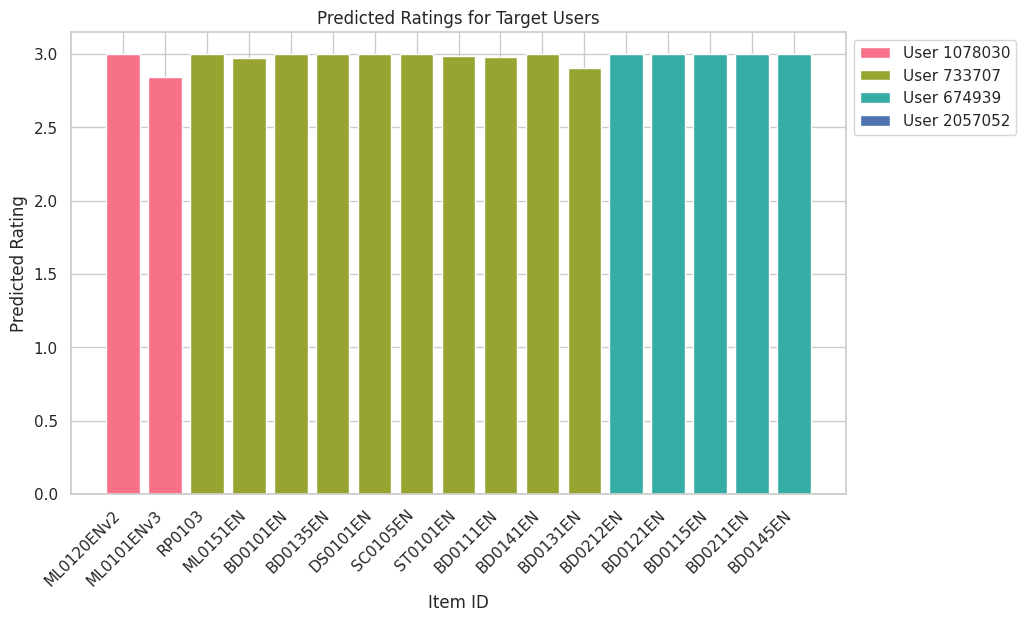

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set the style of seaborn
sns.set(style="whitegrid")


# Set different colors for target users
colors = sns.color_palette('husl', n_colors=len(target_users))

# Create bar chart
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
for i, user_id in enumerate(target_users):
    user_data = predictions_df[predictions_df['User'] == str(user_id)]
    plt.bar(user_data['Item'], user_data['Predicted_Rating'], color=colors[i], label=f'User {user_id}')

# Customize the plot
plt.xlabel('Item ID')
plt.ylabel('Predicted Rating')
plt.title('Predicted Ratings for Target Users')

# Rotate x-labels by 45 degrees
plt.xticks(rotation=45, ha='right')

# Set legend outside the plot
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the plot to a file (choose the format you prefer, e.g., PNG, PDF, SVG)
plt.savefig('06_predicted_ratings_plot_nmf.png', bbox_inches='tight')

# Show the plot
plt.show()

We do not compute ROC AUC since the regression task is not suitable for ROC curve analysis due to the nature of the problem. Instead, we focus on evaluating the model using classification metrics suitable for the binary classification approach applied to the regression problem.

## Implementation Option 2: Use `numpy`, `pandas`, and `sklearn`.
If you do not prefer the one-stop Suprise solution, you may implement the NMF model using `numpy`, `pandas`, and possibly `sklearn`:


### NMF Classification
If we used NMF classification, consider the prediction problem as a classification problem as rating only has two categorical values (`Aduit` vs. `Completion`).

In [36]:
accuracy_list = []
recall_list = []
precision_list = []
f1_score_list = []
#auc = []

# Initialize algorithm
#nmf = NMF(verbose=True, random_state=123)

# - Train the NMF on the trainset, and predict ratings for the testset
#nmf.fit(trainset)

# Predict ratings for the testset
#predictions_nmf_1 = nmf.test(testset)

# Convert predictions to binary labels using a threshold (e.g., 3)
threshold = 3
y_true = [1 if pred.r_ui >= threshold else 0 for pred in predictions_nmf_1]
y_pred = [1 if pred.est >= threshold else 0 for pred in predictions_nmf_1]

# Compute Accuracy
accuracy_nmf_clf = accuracy_score(y_true, y_pred)
accuracy_list.append(accuracy_nmf_clf)

# Compute Precision
precision_nmf_clf = precision_score(y_true, y_pred)  # Requires labels for binary classification
precision_list.append(precision_nmf_clf)

# Compute Recall
recall_nmf_clf = recall_score(y_true, y_pred)  # Requires labels for binary classification
recall_list.append(recall_nmf_clf)

# Compute F1-Score
f1_nmf_clf = f1_score(y_true, y_pred)
f1_score_list.append(f1_nmf_clf)

# Compute AUC (ROC curve is not meaningful for regression, but we can compute AUC for the precision-recall curve)
#auc = roc_auc_score(y_true, y_pred)

print(f"Accuracy: {accuracy_nmf_clf}")
print(f"Precision: {precision_nmf_clf}")
print(f"Recall: {recall_nmf_clf}")
print(f"F1-Score: {f1_nmf_clf}")
#print(f"AUC: {auc}")

# Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame({
    'Accuracy': accuracy_list,
    'Precision': precision_list,
    'Recall': recall_list,
    'F1-Score': f1_score_list,
})    
metrics_df

Accuracy: 0.4123899874271345
Precision: 0.9988295423510593
Recall: 0.3838288430111396
F1-Score: 0.5545543160402903


,Accuracy,Precision,Recall,F1-Score
0,0.41239,0.99883,0.383829,0.554554


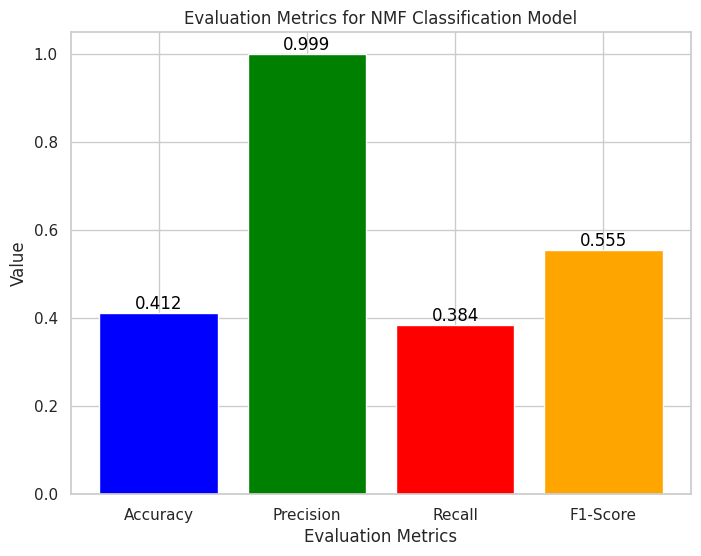

In [37]:
# List of evaluation metrics
eva_metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

# Corresponding values
eva_values = [accuracy_nmf_clf, precision_nmf_clf, recall_nmf_clf, f1_nmf_clf]

# Plotting the graph
plt.figure(figsize=(8, 6))
bars = plt.bar(eva_metrics, eva_values, color=['blue', 'green', 'red', 'orange'])

# Adding labels and title
plt.xlabel('Evaluation Metrics')
plt.ylabel('Value')
plt.title('Evaluation Metrics for NMF Classification Model')

# Adding y-values on the bars
for bar, value in zip(bars, eva_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3), 
             ha='center', va='bottom', color='black')

# Save the figure
plt.savefig('07_nmf_clf_evaluation_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()


In [38]:
# Compute MAE, MSE, RMSE
mae_nmf_clf = mean_absolute_error(y_true, y_pred)
mse_nmf_clf = mean_squared_error(y_true, y_pred)
rmse_nmf_clf = np.sqrt(mse_knn_clf)

print(f"MAE: {mae_nmf_clf}")
print(f"MSE: {mse_nmf_clf}")
print(f"RMSE: {rmse_nmf_clf}")

MAE: 0.5876100125728655
MSE: 0.5876100125728655
RMSE: 0.20491586859369565


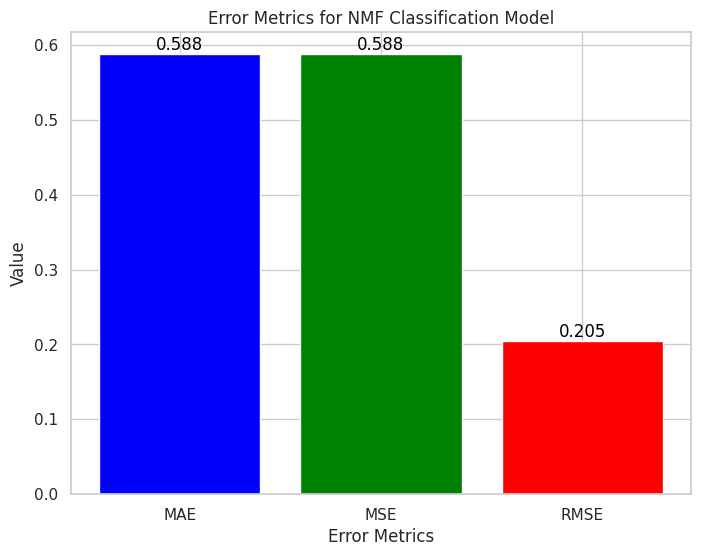

In [39]:
# List of error metrics
error_metrics = ['MAE', 'MSE', 'RMSE']

# Corresponding values
error_values = [mae_nmf_clf, mse_nmf_clf, rmse_nmf_clf]

# Plotting the graph
plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Error Metrics for NMF Classification Model')

# Adding y-values on the bars
for bar, value in zip(bars, error_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3),
             ha='center', va='bottom', color='black')  # Fixing the 'va' parameter

# Save the figure
plt.savefig('08_nmf_clf_error_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()

In classification, we use metrics like accuracy, precision, recall, and F1-score to evaluate the performance of the model in predicting categorical labels.
In regression, we use metrics like MAE, MSE, and RMSE to evaluate the performance of the model in predicting continuous values.

<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Execute</h1></div>

# Summary
In this lab, you have learned and practiced Non-negative Matrix Factorization (NMF)-based collaborative filtering. The basic idea is to decompose the original user-item interaction matrix into two smaller and dense user and item matrices. Then, we have built the two matrices, we can easily estimate the unknown ratings via the dot product of specific row in user matrix and specific column in item matrix.
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The NMF-based collaborative filtering results
    <li>Factorized matrices with non-negative values, providing an interpretable representation of users and items.
    <li>Relies on the underlying patterns and features present in the user-item interaction matrix.
    <li>New users or items based on the preferences of similar entities.Similar users or items are used to infer preferences for new entities.
    <li>Relies on the local neighborhood of users or items, and it can find meaningful connections.    
</ol>


<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h1><a id="Coll_NN">Course Rating Prediction using Neural Networks</a>

In [40]:
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers

In [41]:
num_users = len(ratings_df['user'].unique())
num_items = len(ratings_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


#### Implementing the recommender neural network using tensorflow 

This network architecture could be defined and implemented as a sub-class inheriting the `tensorflow.keras.Model` super class, let's call it `RecommenderNet()`.

In [42]:
class RecommenderNet(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.relu(x)

### Train and evaluate the RecommenderNet()

Now it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.

In [43]:
def process_dataset(raw_data):
    
    encoded_data = raw_data.copy()
    
    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist()
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)}
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)}
    
    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist()
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)}
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)}

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict

In [44]:
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(ratings_df)

In [45]:
encoded_data.head()

,user,item,rating
0,0,0,3
1,1,1,3
2,2,2,3
3,3,3,3
4,4,4,3


Then we can split the encoded dataset into training and testing datasets.


In [46]:
def generate_train_test_datasets(dataset, scale=True):

    min_rating = min(dataset["rating"])
    max_rating = max(dataset["rating"])

    dataset = dataset.sample(frac=1, random_state=42)
    x = dataset[["user", "item"]].values
    if scale:
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        y = dataset["rating"].values

    # Assuming training on 80% of the data and validating on 10%, and testing 10%
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])

    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices],
        x[train_indices:test_indices],
        x[test_indices:],
        y[:train_indices],
        y[train_indices:test_indices],
        y[test_indices:],
    )
    return x_train, x_val, x_test, y_train, y_val, y_test

In [47]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

In [48]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [49]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

and training output labels are a list of 0s and 1s indicating if the user has completed a course or not.

In [50]:
y_train

array([1., 1., 1., ..., 1., 0., 1.])

Then we can choose a small embedding vector size to be 16 and create a `RecommenderNet()` model to be trained

In [51]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

Train the RecommenderNet() model_

In [52]:
## - call model.compile() method to set up the loss and optimizer and metrics for the model training, you may use
##  - - tf.keras.losses.MeanSquaredError() as training loss
##  - - keras.optimizers.Adam() as optimizer
##  - - tf.keras.metrics.RootMeanSquaredError() as metric

## - call model.fit() to train the model

## - optionally call model.save() to save the model

## - plot the train and validation loss
model.compile(optimizer="adam", loss="mean_squared_error", metrics=["mean_squared_error"])

Evaluate the trained model

In [53]:
### - call model.evaluate() to evaluate the model
history = model.fit(x_train, y_train, validation_split = 0.1, epochs=20, batch_size=512)

Epoch 1/20
329/329 [==============================] - 4s 9ms/step - loss: 0.3351 - mean_squared_error: 0.3350 - val_loss: 0.0609 - val_mean_squared_error: 0.0608
Epoch 2/20
329/329 [==============================] - 3s 9ms/step - loss: 0.2737 - mean_squared_error: 0.2736 - val_loss: 0.8622 - val_mean_squared_error: 0.8620
Epoch 3/20
329/329 [==============================] - 3s 9ms/step - loss: 0.6408 - mean_squared_error: 0.6406 - val_loss: 0.0674 - val_mean_squared_error: 0.0672
Epoch 4/20
329/329 [==============================] - 3s 9ms/step - loss: 0.1632 - mean_squared_error: 0.1629 - val_loss: 0.7694 - val_mean_squared_error: 0.7691
Epoch 5/20
329/329 [==============================] - 3s 9ms/step - loss: 0.0800 - mean_squared_error: 0.0796 - val_loss: 0.4413 - val_mean_squared_error: 0.4409
Epoch 6/20
329/329 [==============================] - 3s 9ms/step - loss: 0.0681 - mean_squared_error: 0.0678 - val_loss: 0.6245 - val_mean_squared_error: 0.6242
Epoch 7/20
329/329 [========

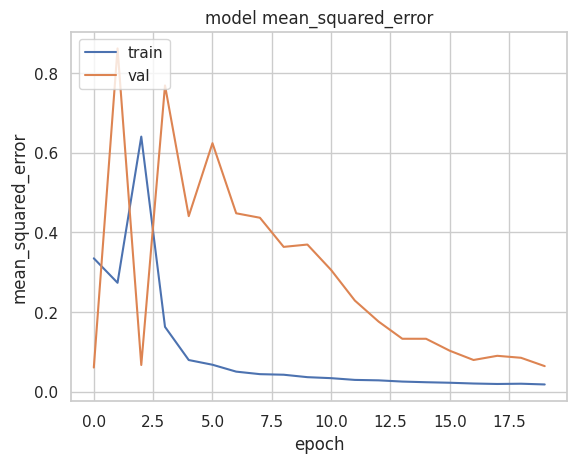

In [54]:
## - optionally call model.save() to save the model
## - plot the train and validation loss
from matplotlib import pyplot as plt
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [55]:

### - call model.evaluate() to evaluate the model
model.evaluate(x_test, y_test)

730/730 [==============================] - 2s 3ms/step - loss: 0.2425 - mean_squared_error: 0.2418


[0.24249276518821716, 0.24176369607448578]

### Extract the user and item embedding vectors as latent feature vectors


In [56]:
model.summary()

Model: "recommender_net"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embed  multiple                 542416    
 ding)                                                           
                                                                 
 user_bias (Embedding)       multiple                  33901     
                                                                 
 item_embedding_layer (Embed  multiple                 2016      
 ding)                                                           
                                                                 
 item_bias (Embedding)       multiple                  126       
                                                                 
Total params: 578,459
Trainable params: 578,459
Non-trainable params: 0
_________________________________________________________________


In [57]:
from sklearn import metrics
# Train the model (if not already trained)
#history = model.fit(x_train, y_train, validation_split = 0.1, epochs=20, batch_size=512)
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epoch)

# Predict ratings for the test data
nn_prediction = model.predict(x_test)

# Calculate evaluation metrics
mae_nn = metrics.mean_absolute_error(y_test, nn_prediction)
mse_nn = metrics.mean_squared_error(y_test, nn_prediction)
rmse_nn = np.sqrt(mse_nn)

print(f"Mean Absolute Error (MAE): {mae_nn}")
print(f"Mean Squared Error (MSE): {mse_nn}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn}")

730/730 [==============================] - 2s 2ms/step
Mean Absolute Error (MAE): 0.48228857496379784
Mean Squared Error (MSE): 0.24176372205243024
Root Mean Squared Error (RMSE): 0.4916947447882988


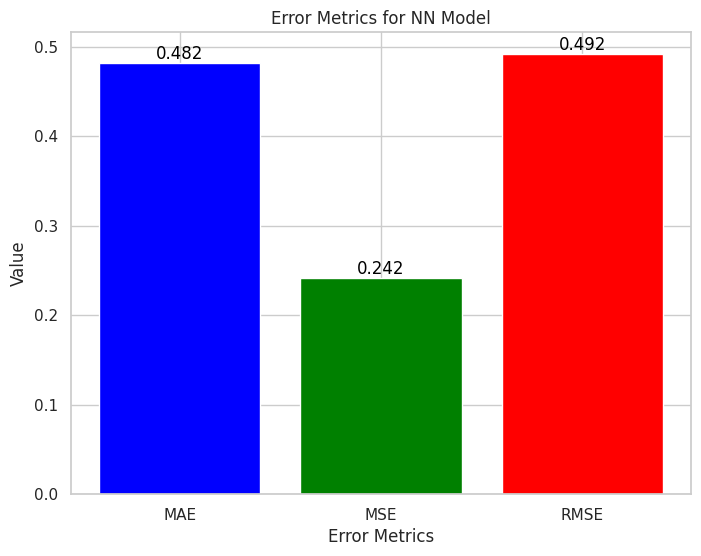

In [58]:
# List of error metrics
error_metrics = ['MAE', 'MSE', 'RMSE']

# Corresponding values
error_values = [mae_nn, mse_nn, rmse_nn]

# Plotting the graph
plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Error Metrics for NN Model')

# Adding y-values on the bars
for bar, value in zip(bars, error_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3),
             ha='center', va='bottom', color='black')  # Fixing the 'va' parameter

# Save the figure
plt.savefig('09_nn_error_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()

### NN Classification

If we used NN classification, consider the prediction problem as a classification problem as rating only has two categorical values (`Aduit` vs. `Completion`).

In [59]:
# Convert predictions to binary labels
threshold = 3  # Adjust threshold as needed
binary_predictions = [1 if pred >= threshold else 0 for pred in nn_prediction]

# Calculate accuracy
accuracy_nn = accuracy_score(y_test, binary_predictions)

# Calculate AUC
#auc_nn = roc_auc_score(y_test, nn_prediction)

# Calculate precision
precision_nn = precision_score(y_test, binary_predictions)

# Calculate recall
recall_nn = recall_score(y_test, binary_predictions)

# Calculate F1 score
f1_nn = f1_score(y_test, binary_predictions)

print(f"Accuracy: {accuracy_nn}")
print(f"Precision: {precision_nn}")
print(f"Recall: {recall_nn}")
print(f"F1 Score: {f1_nn}")

Accuracy: 0.045561699027045564
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


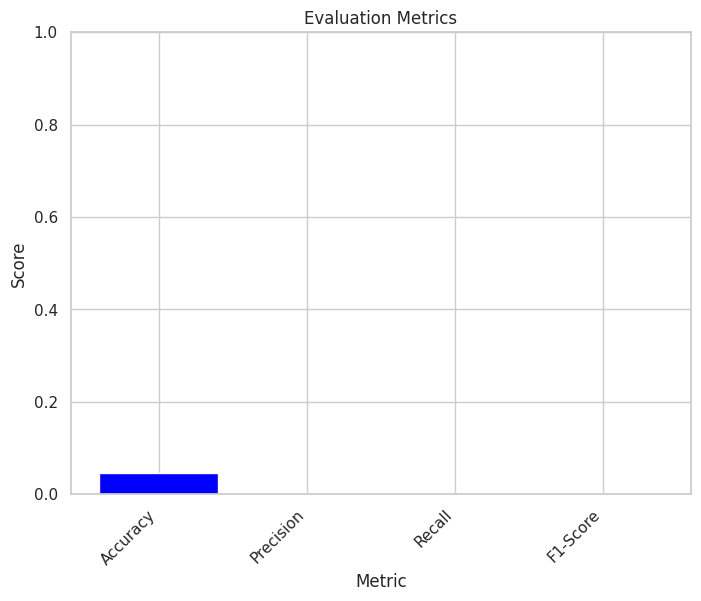

In [60]:
#Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy_nn, precision_nn, recall_nn, f1_nn]
})

# Plotting the evaluation metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'green', 'red','orange'])
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for better visualization
# Save the plot to a file (choose the format you prefer, e.g., PNG, PDF, SVG)
plt.savefig('10_Evaluation_metric_nn.png', bbox_inches='tight')

plt.show()

We can easily get the actual weights using `model.get_layer().get_weights()` methods


In [61]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [62]:
user_latent_features[0]

array([-0.00192205, -0.01126975,  0.00272593,  0.00943454,  0.01300121,
       -0.00728882,  0.03612695, -0.0074418 , -0.02335742,  0.01724067,
        0.02440019, -0.01342227, -0.01442252, -0.01979428,  0.01321375,
        0.04970181], dtype=float32)

In [63]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [64]:
item_latent_features[0]

array([ 0.00609554,  0.01593854, -0.00115514, -0.01481513,  0.01160559,
       -0.00206659,  0.03011299,  0.00691826, -0.00872511,  0.00356866,
        0.01768038,  0.01339107,  0.01845549,  0.03625929,  0.02508449,
        0.02793382], dtype=float32)

In [65]:
# Define target users and items
target_users = [1078030, 733707, 674939, 2057052]
item_ids = ['ML0151EN','ML0101ENv3']  # Assuming only one item ID is considered

# Initialize a list to store the results
results_list = []

# Generate predictions for the specified users and items
for user_id in target_users:
    for item_id in item_ids:
        try:
            # Assuming model.predict returns a tuple containing (user_id, item_id, predicted_rating)
            prediction = model.predict(user_id, item_id)
            
            # Extract predicted rating from the prediction tuple
            predicted_rating = prediction[2]
            
            # Append the result to the list
            results_list.append({
                'User': user_id,
                'Item': item_id,
                'Predicted Rating': predicted_rating
            })
        except IndexError:
            # Handle the case when the prediction tuple does not have the expected structure
            print(f"Prediction tuple for user {user_id}, item {item_id}, rating {predicted_rating}, does not have the expected structure")
        except Exception as e:
            # Print any other exceptions that may occur during prediction
            print(f"Error predicting rating for user {user_id}, item {item_id}: {str(e)}, rating {predicted_rating},")

# If no predictions are available, create a DataFrame with default values
if not results_list:
    results_list.append({
        'User': None,
        'Item': None,
        'Predicted Rating': None
    })

# Create a DataFrame from the list of results
results_df = pd.DataFrame(results_list)

print(results_df)

Prediction tuple for user 1078030, item ML0151EN, rating 3, does not have the expected structure
Prediction tuple for user 1078030, item ML0101ENv3, rating 3, does not have the expected structure
Prediction tuple for user 733707, item ML0151EN, rating 3, does not have the expected structure
Prediction tuple for user 733707, item ML0101ENv3, rating 3, does not have the expected structure
Prediction tuple for user 674939, item ML0151EN, rating 3, does not have the expected structure
Prediction tuple for user 674939, item ML0101ENv3, rating 3, does not have the expected structure
Prediction tuple for user 2057052, item ML0151EN, rating 3, does not have the expected structure
Prediction tuple for user 2057052, item ML0101ENv3, rating 3, does not have the expected structure
   User  Item Predicted Rating
0  None  None             None


In [66]:
results_df.head()

,User,Item,Predicted Rating
0,None,None,None


<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h3><a id="Opt_3">TASK (Optional): Customize the RecommenderNet to potentially improve the model performance</a> 

The pre-defined `RecommenderNet()` is a actually very basic neural network, you are encouraged to customize it to see if model prediction performance will be improved. Here are some directions:
- Hyperparameter tuning, such as the embedding layer dimensions
- Add more hidden layers
- Try different activation functions such as `ReLu`


In [67]:
## WRITE YOUR CODE HERE

## Update RecommenderNet() class

## compile and fit the updated model

## evaluate the updated model
class RecommenderNetPlus(keras.Model):
    
    def __init__(self, num_users, num_items, embedding_size=32, **kwargs):
        """
           Constructor
           :param int num_users: number of users
           :param int num_items: number of items
           :param int embedding_size: the size of embedding vector
        """
        super(RecommenderNetPlus, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size
        
        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")
        
        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")
        
    def call(self, inputs):
        """
           method to be called during model fitting
           
           :param inputs: user and item one-hot vectors
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        user_bias = self.user_bias(inputs[:, 0])
        item_vector = self.item_embedding_layer(inputs[:, 1])
        item_bias = self.item_bias(inputs[:, 1])
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Sigmoid output layer to output the probability
        return tf.nn.elu(x)

In [68]:
model1 = RecommenderNetPlus(num_users, num_items, 10)
model1.compile(optimizer="nadam", loss="mean_squared_error", metrics=["mean_squared_error"])
history = model1.fit(x_train, y_train, validation_split = 0.1, epochs=20, batch_size=512)

Epoch 1/20
329/329 [==============================] - 4s 9ms/step - loss: 0.2816 - mean_squared_error: 0.2816 - val_loss: 0.0492 - val_mean_squared_error: 0.0491
Epoch 2/20
329/329 [==============================] - 3s 8ms/step - loss: 0.0894 - mean_squared_error: 0.0893 - val_loss: 0.6718 - val_mean_squared_error: 0.6717
Epoch 3/20
329/329 [==============================] - 3s 8ms/step - loss: 0.0661 - mean_squared_error: 0.0660 - val_loss: 0.1879 - val_mean_squared_error: 0.1877
Epoch 4/20
329/329 [==============================] - 3s 8ms/step - loss: 0.0564 - mean_squared_error: 0.0563 - val_loss: 0.4424 - val_mean_squared_error: 0.4423
Epoch 5/20
329/329 [==============================] - 3s 9ms/step - loss: 0.0466 - mean_squared_error: 0.0465 - val_loss: 0.2274 - val_mean_squared_error: 0.2272
Epoch 6/20
329/329 [==============================] - 3s 8ms/step - loss: 0.0429 - mean_squared_error: 0.0427 - val_loss: 0.2386 - val_mean_squared_error: 0.2384
Epoch 7/20
329/329 [========

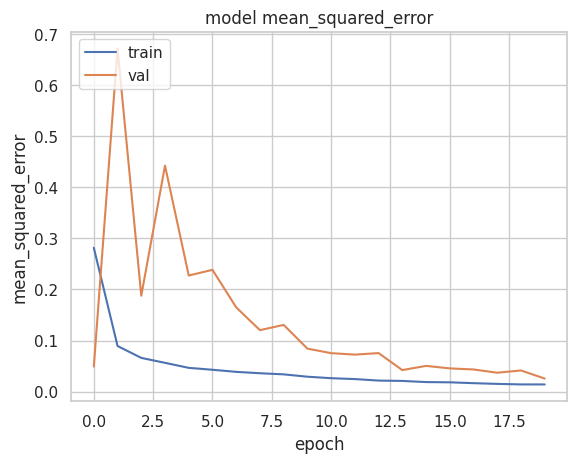

In [69]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model mean_squared_error')
plt.ylabel('mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [70]:
model1.evaluate(x_test, y_test)

730/730 [==============================] - 2s 3ms/step - loss: 0.2554 - mean_squared_error: 0.2550


[0.2553664743900299, 0.2549770474433899]

In [71]:
model1.summary()

Model: "recommender_net_plus"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 user_embedding_layer (Embed  multiple                 339010    
 ding)                                                           
                                                                 
 user_bias (Embedding)       multiple                  33901     
                                                                 
 item_embedding_layer (Embed  multiple                 1260      
 ding)                                                           
                                                                 
 item_bias (Embedding)       multiple                  126       
                                                                 
Total params: 374,297
Trainable params: 374,297
Non-trainable params: 0
_________________________________________________________________


In [72]:
from sklearn import metrics
# Train the model (if not already trained)
#history = model.fit(x_train, y_train, validation_split = 0.1, epochs=20, batch_size=512)
#history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epoch)

# Predict ratings for the test data
nn_prediction_1 = model1.predict(x_test)

# Calculate evaluation metrics
mae_nn_1 = metrics.mean_absolute_error(y_test, nn_prediction_1)
mse_nn_1 = metrics.mean_squared_error(y_test, nn_prediction_1)
rmse_nn_1 = np.sqrt(mse_nn)

print(f"Mean Absolute Error (MAE): {mae_nn_1}")
print(f"Mean Squared Error (MSE): {mse_nn_1}")
print(f"Root Mean Squared Error (RMSE): {rmse_nn_1}")

730/730 [==============================] - 2s 2ms/step
Mean Absolute Error (MAE): 0.4989838617530127
Mean Squared Error (MSE): 0.25497700886604524
Root Mean Squared Error (RMSE): 0.4916947447882988


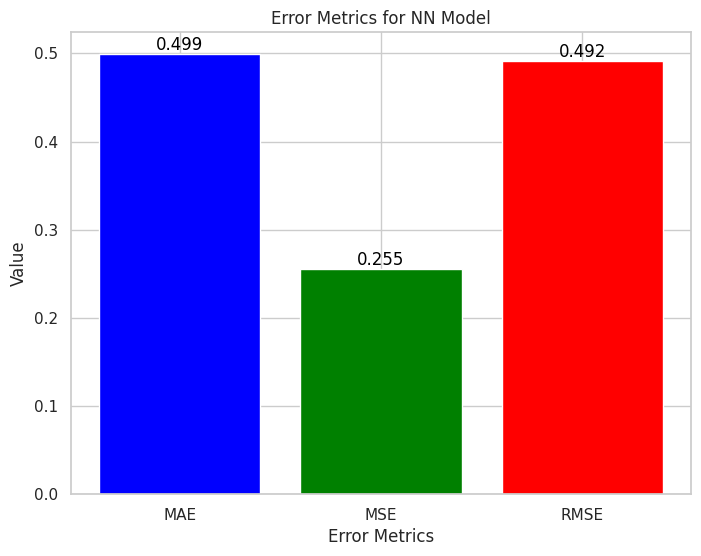

In [73]:
# List of error metrics
error_metrics = ['MAE', 'MSE', 'RMSE']

# Corresponding values
error_values = [mae_nn_1, mse_nn_1, rmse_nn_1]

# Plotting the graph
plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Error Metrics for NN Model')

# Adding y-values on the bars
for bar, value in zip(bars, error_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3),
             ha='center', va='bottom', color='black')  # Fixing the 'va' parameter

# Save the figure
plt.savefig('11_nn_1_error_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()

### NN Classification

If we used NN classification, consider the prediction problem as a classification problem as rating only has two categorical values (`Aduit` vs. `Completion`).

In [74]:
# Convert predictions to binary labels
threshold = 3  # Adjust threshold as needed
binary_predictions_1 = [1 if pred >= threshold else 0 for pred in nn_prediction_1]

# Calculate accuracy
accuracy_nn_1 = accuracy_score(y_test, binary_predictions_1)

# Calculate AUC
#auc_nn = roc_auc_score(y_test, nn_prediction)

# Calculate precision
precision_nn_1 = precision_score(y_test, binary_predictions_1)

# Calculate recall
recall_nn_1 = recall_score(y_test, binary_predictions_1)

# Calculate F1 score
f1_nn_1 = f1_score(y_test, binary_predictions_1)

print(f"Accuracy: {accuracy_nn_1}")
print(f"Precision: {precision_nn_1}")
print(f"Recall: {recall_nn_1}")
print(f"F1 Score: {f1_nn_1}")

Accuracy: 0.045561699027045564
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


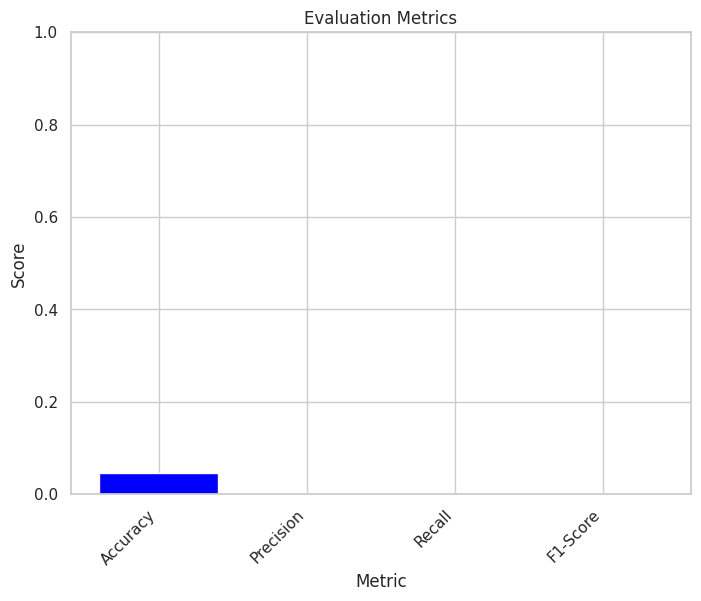

In [75]:
#Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score'],
    'Score': [accuracy_nn_1, precision_nn_1, recall_nn_1, f1_nn_1]
})

# Plotting the evaluation metrics
plt.figure(figsize=(8, 6))
plt.bar(metrics_df['Metric'], metrics_df['Score'], color=['blue', 'green', 'red','orange'])
plt.title('Evaluation Metrics')
plt.xlabel('Metric')
plt.ylabel('Score')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 1)  # Set y-axis limit to 0-1 for better visualization
# Save the plot to a file (choose the format you prefer, e.g., PNG, PDF, SVG)
plt.savefig('12_Evaluation_metric_nn_1.png', bbox_inches='tight')

plt.show()

<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Execute</h1></div>

# Summary
Neural Network-based collaborative filtering, with a predefined and trained neural network, we can extract or embed users and items into latent feature spaces and further predict the interaction between a user and an item with the latent feature vectors.
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The Neural Network-based collaborative filtering results
    <li>Capture complex, non-linear relationships in course-rating data, allowing for more accurate modeling of user preferences.
    <li>The learned embeddings can capture latent factors and provide insights into the underlying features influencing course ratings.
    <li>Handling implicit feedback, such as user interactions and engagement, which may not be explicitly rated.
</ol>


<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h1><a id="Reg_Bas">Regression-based Rating Score Prediction using Embedding Features</a> 

In [76]:
user_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/user_embeddings.csv"
item_emb_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/datasets/course_embeddings.csv"

In [77]:
# Load user embeddings
user_emb = pd.read_csv(user_emb_url)
# Load item embeddings
item_emb = pd.read_csv(item_emb_url)

### User embedding feature vector

In [78]:
user_emb.head()

,user,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,UFeature7,UFeature8,UFeature9,UFeature10,UFeature11,UFeature12,UFeature13,UFeature14,UFeature15
0,1889878,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,0.091464,-0.040247,0.018958,-0.153328,-0.090143,0.082830,-0.058721,0.057929,-0.001472
1,1342067,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,0.104128,-0.034401,0.004011,0.064832,0.165857,-0.004384,0.053257,0.014308,0.056684
2,1990814,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,-0.156026,0.039269,0.042195,0.014695,-0.115989,0.031158,0.102021,-0.020601,0.116488
3,380098,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,-0.060944,0.112384,0.002114,0.090660,-0.068545,0.008967,0.063962,0.052347,0.018072
4,779563,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,-0.019367,-0.031341,0.064896,-0.048158,-0.047309,-0.007544,0.010474,-0.032287,-0.083983


### Item embedding feature vector

In [79]:
item_emb.head()

,item,CFeature0,CFeature1,CFeature2,CFeature3,CFeature4,CFeature5,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,CC0101EN,0.009657,-0.005238,-0.004098,0.016303,-0.005274,-0.000361,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,CL0101EN,-0.008611,0.028041,0.021899,-0.001465,0.006900,-0.017981,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,ML0120ENv3,0.027439,-0.027649,-0.007484,-0.059451,0.003972,0.020496,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,BD0211EN,0.020163,-0.011972,-0.003714,-0.015548,-0.007540,0.014847,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,DS0101EN,0.006399,0.000492,0.005640,0.009639,-0.005487,-0.000590,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


In [80]:
# Merge user embedding features
user_emb_merged = pd.merge(ratings_df, user_emb, how='left', left_on='user', right_on='user').fillna(0)
# Merge course embedding features
merged_df = pd.merge(user_emb_merged, item_emb, how='left', left_on='item', right_on='item').fillna(0)

In [81]:
merged_df.head()

,user,item,rating,UFeature0,UFeature1,UFeature2,UFeature3,UFeature4,UFeature5,UFeature6,...,CFeature6,CFeature7,CFeature8,CFeature9,CFeature10,CFeature11,CFeature12,CFeature13,CFeature14,CFeature15
0,1889878,CC0101EN,3.0,0.080721,-0.129561,0.087998,0.030231,0.082691,-0.004176,-0.003480,...,-0.015081,-0.012229,0.015686,0.008401,-0.035495,0.009381,-0.032560,-0.007292,0.000966,-0.006218
1,1342067,CL0101EN,3.0,0.068047,-0.112781,0.045208,-0.007570,-0.038382,0.068037,0.114949,...,0.010899,-0.037610,-0.019397,-0.025682,-0.000620,0.038803,0.000196,-0.045343,0.012863,0.019429
2,1990814,ML0120ENv3,3.0,0.124623,0.012910,-0.072627,0.049935,0.020158,0.133306,-0.035366,...,-0.012695,0.036138,0.019965,0.018686,-0.010450,-0.050011,0.013845,-0.044454,-0.001480,-0.007559
3,380098,BD0211EN,3.0,-0.034870,0.000715,0.077406,0.070311,-0.043007,-0.035446,0.032846,...,-0.005700,-0.006068,-0.005792,-0.023036,0.015999,-0.023480,0.015469,0.022221,-0.023115,-0.001785
4,779563,DS0101EN,3.0,0.106414,-0.001887,-0.017211,-0.042277,-0.074953,-0.056732,0.074610,...,-0.010015,-0.001514,-0.017598,0.003590,0.016799,0.002732,0.005162,0.015031,-0.000877,-0.021283


Combine the user features (the column labels starting with `UFeature` and item features (the column labels starting with `CFeature`. Aggregate two feature vectors using tools such as element-wise add, multiply, max/min, average, etc. Here we simply add the two sets of feature columns:

In [82]:
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
regression_dataset = user_embeddings + course_embeddings.values
regression_dataset.columns = [f"Feature{i}" for i in range(16)]
regression_dataset['rating'] = ratings
regression_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,3.0
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3.0
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,3.0
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,3.0
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3.0


By now, we have built the input dataset `X` and the output vector `y`:

In [83]:
X = regression_dataset.iloc[:, :-1]
y = regression_dataset.iloc[:, -1]
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


## Perform regression on the interaction dataset

In an online course system, consider the `Completion` mode to be `larger` than the `Audit` mode as a learner needs to put more efforts towards completion.  Now if we treat it as a regression problem,  we would expect the regression model to output ratings ranging from 2.0 to 3.0. To interpret regression model output, we can treat values closer to 2.0 as `Audit` and values closer to 3.0 as `Completion`.

Use sklearn to train and evaluate various regression models.

In [84]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split #forget code appear TypeError: train_test_split() got multiple values for argument 'test_size'
from sklearn import metrics
import numpy as np

First split dataset into training and testing datasets_

In [85]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

Create a basic linear regression model_

In [86]:
# Scaling the data
y_train= y_train.values.reshape(-1,1)
y_test= y_test.values.reshape(-1,1)

sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)
y_train = sc_X.fit_transform(y_train)
y_test = sc_y.fit_transform(y_test)

Train the basic regression model with training data_

In [87]:
### WRITE YOUR CODE HERE
lm = LinearRegression()
lm.fit(X_train,y_train)
lm_prediction = lm.predict(X_test)

Evaluate the basic regression model_

In [88]:
### The main evaluation metric is RMSE but you may use other metrics as well
mae_lm = metrics.mean_absolute_error(y_test, lm_prediction)
mse_lm =  metrics.mean_squared_error(y_test, lm_prediction)
rmse_lm =  np.sqrt(mse_lm)

print('MAE:', mae_lm)
print('MSE:', mse_lm)
print('RMSE:', rmse_lm)

MAE: 0.41428838083033687
MSE: 0.9932500760760065
RMSE: 0.9966193235513781


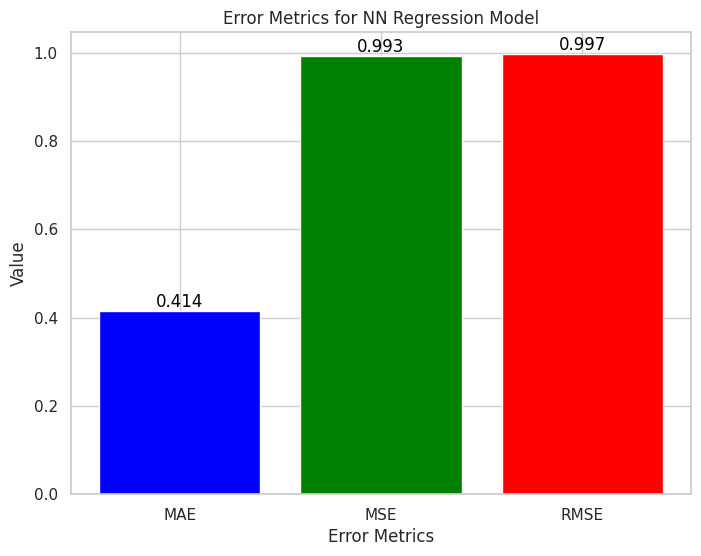

In [89]:
# List of error metrics
error_metrics = ['MAE', 'MSE', 'RMSE']

# Corresponding values
error_values = [mae_lm, mse_lm, rmse_lm]

# Plotting the graph
plt.figure(figsize=(8, 6))
bars = plt.bar(error_metrics, error_values, color=['blue', 'green', 'red'])

# Adding labels and title
plt.xlabel('Error Metrics')
plt.ylabel('Value')
plt.title('Error Metrics for NN Regression Model')

# Adding y-values on the bars
for bar, value in zip(bars, error_values):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), round(value, 3),
             ha='center', va='bottom', color='black')  # Fixing the 'va' parameter

# Save the figure
plt.savefig('13_nn_reg_error_metrics.png', bbox_inches='tight')

# Display the plot
plt.show()

In [90]:
## Assuming lm_prediction is a 2D array, reshape it to 1D
lm_prediction_1d = lm_prediction.flatten()

# Create DataFrame with predictions
predictions_df = pd.DataFrame({'Predicted_Rating': lm_prediction_1d})

# Display the DataFrame
print(predictions_df)

       Predicted_Rating
0              0.079560
1              0.003520
2             -0.020586
3             -0.097637
4             -0.081726
...                 ...
46657         -0.110817
46658          0.114607
46659          0.061304
46660          0.073647
46661          0.095189

[46662 rows x 1 columns]


If you're working with regression tasks, metrics like accuracy, AUC (Area Under the ROC Curve), and F1 Score are not applicable because they are typically used for classification tasks. For regression tasks, Mean Absolute Error (MAE), Mean Squared Error (MSE), and Root Mean Squared Error (RMSE) are more commonly used metrics to evaluate model performance.

However, if you're interested in evaluating the performance of your regression model using alternative metrics, you can use metrics like R-squared (coefficient of determination) or adjusted R-squared, which provide information about the proportion of variance explained by the model.

In [91]:
from sklearn.metrics import r2_score
# Calculate R-squared
r_squared = r2_score(y_test, lm_prediction)

print('R-squared:', r_squared)

R-squared: 0.006749923923993872


In [92]:
# Calculate R-squared
r_squared_1d = r2_score(y_test, lm_prediction_1d)

print('R-squared_1d:', r_squared_1d)

R-squared_1d: 0.006749923923993872


A negative R-squared value can occur when the model's predictions are systematically worse than the mean of the observed data. It suggests that the model is not capturing the underlying patterns in the data and may indicate that the model is not suitable for making predictions.

In summary, a negative R-squared value suggests that the regression model does not provide any explanatory power and may not be useful for making predictions on the given data. It's important to further investigate the model and data to understand why the R-squared value is negative and consider alternative modeling approaches if necessary.

<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Execute</h1></div>

# Summary
We have built regression models to predict numerical course ratings using the embedding feature vectors extracted from neural networks.
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The regression models to predict numerical course ratings using the embedding feature vectors extracted from neural networks filtering results
    <li>Capture latent factors and relationships that contribute to the prediction of rating scores.
    <li>The embedding features implicitly learn latent factors without the need for explicit feature engineering. A more accurate representations of complex relationships in the data.
    <li>The learned  embeddings enable the model to understand underlying patterns that contribute to rating scores.
    <li>Provide a dense representation that captures similarities between courses and users.
    <li>Users and courses with similar embeddings share common features, aiding interpretability.
</ol>

<img style="float:left" src="https://i.imgur.com/J4M3HKM.png" width="50">

# Construct Stage

<h1><a id="Cls_Bas">Classification-based Rating Mode Prediction using Embedding Features</a>

Consider the prediction problem as a classification problem as rating only has two categorical values (`Aduit` vs. `Completion`).

In [93]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [94]:
u_feautres = [f"UFeature{i}" for i in range(16)]
c_features = [f"CFeature{i}" for i in range(16)]

user_embeddings = merged_df[u_feautres]
course_embeddings = merged_df[c_features]
ratings = merged_df['rating']

# Aggregate the two feature columns using element-wise add
interaction_dataset = user_embeddings + course_embeddings.values
interaction_dataset.columns = [f"Feature{i}" for i in range(16)]
interaction_dataset['rating'] = ratings
interaction_dataset.head()

,Feature0,Feature1,Feature2,Feature3,Feature4,Feature5,Feature6,Feature7,Feature8,Feature9,Feature10,Feature11,Feature12,Feature13,Feature14,Feature15,rating
0,0.090378,-0.134799,0.083900,0.046534,0.077417,-0.004537,-0.018561,0.079236,-0.024561,0.027359,-0.188823,-0.080762,0.050271,-0.066013,0.058894,-0.007689,3.0
1,0.059437,-0.084740,0.067107,-0.009036,-0.031482,0.050057,0.125847,0.066517,-0.053798,-0.021671,0.064212,0.204660,-0.004188,0.007914,0.027170,0.076114,3.0
2,0.152061,-0.014739,-0.080112,-0.009516,0.024130,0.153802,-0.048061,-0.119888,0.059234,0.060882,0.004244,-0.166000,0.045002,0.057566,-0.022081,0.108929,3.0
3,-0.014707,-0.011257,0.073692,0.054763,-0.050547,-0.020599,0.027146,-0.067012,0.106593,-0.020921,0.106658,-0.092025,0.024436,0.086183,0.029232,0.016287,3.0
4,0.112812,-0.001395,-0.011572,-0.032638,-0.080440,-0.057321,0.064595,-0.020880,-0.048939,0.068486,-0.031359,-0.044577,-0.002381,0.025505,-0.033164,-0.105266,3.0


Next, let's use `LabelEncoder()` to encode our `rating` label to be categorical:

In [95]:
X = interaction_dataset.iloc[:, :-1]
y_raw = interaction_dataset.iloc[:, -1]

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y_raw.values.ravel())

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rs)

In [97]:
print(f"Input data shape: {X.shape}, Output data shape: {y.shape}")

Input data shape: (233306, 16), Output data shape: (233306,)


### Perform classification tasks on the interaction dataset

In [98]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import roc_auc_score

Define classification models such as Logistic Regression, Tree models, SVM, Bagging, and Boosting models_

In [99]:
# You may need to tune the hyperparameters of the models
models = [LogisticRegression(random_state=rs),
          DecisionTreeClassifier(random_state=rs),
          SVC(gamma='auto', random_state=rs),
          BaggingClassifier(base_estimator=SVC(),
                            n_estimators=10, random_state=rs),
          GradientBoostingClassifier(
              n_estimators=100, learning_rate=1.0, max_depth=1, random_state=rs)
          ]

names = [
    'LogisticRegression',
    'DecisionTreeClassifier',
    'SVC',
    'BaggingClassifier',
    'GradientBoostingClassifier'
]

Train your classification models with training data_

In [100]:
### You may need to tune the hyperparameters of the models
accuracy = []
recall = []
precision = []
f_score = []
auc = []

for i in range(len(models)):
    clf = models[i].fit(X_train, y_train)
    y_pred = models[i].predict(X_test)
    mean_acc = clf.score(X_test, y_test)
    accuracy.append(mean_acc)
    p, r, fbeta_score, _ = precision_recall_fscore_support(
        y_test, y_pred, average=None, labels=[1])
    precision.append(p[0])
    recall.append(r[0])
    f_score.append(fbeta_score[0])
    a = roc_auc_score(y_test, y_pred)
    auc.append(a)
    print(f'{names[i]} -> mean accuracy: {mean_acc} precision: {p[0]} recall: {r[0]} f_score: {fbeta_score[0]} auc: {a}')
    
# Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame({
    'Model': names,
    'Accuracy': accuracy,
    'Precision': precision,
    'Recall': recall,
    'F1-Score': f_score,
    'AUC': auc
})

metrics_df

LogisticRegression -> mean accuracy: 0.9545025931164545 precision: 0.9545025931164545 recall: 1.0 f_score: 0.9767217464720782 auc: 0.5
DecisionTreeClassifier -> mean accuracy: 0.9612532681839613 precision: 0.9814543569867273 recall: 0.9778845506185591 f_score: 0.9796662018084484 auc: 0.795112788733679
SVC -> mean accuracy: 0.9545025931164545 precision: 0.9545025931164545 recall: 1.0 f_score: 0.9767217464720782 auc: 0.5


/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


BaggingClassifier -> mean accuracy: 0.9837126569799837 precision: 0.986595531843948 recall: 0.9964749994386942 f_score: 0.9915106563603057 auc: 0.8562214846463372
GradientBoostingClassifier -> mean accuracy: 0.974990356178475 precision: 0.9781285827674399 recall: 0.9960708592469522 f_score: 0.9870181878858669 auc: 0.7644037763027035


,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,LogisticRegression,0.954503,0.954503,1.000000,0.976722,0.500000
1,DecisionTreeClassifier,0.961253,0.981454,0.977885,0.979666,0.795113
2,SVC,0.954503,0.954503,1.000000,0.976722,0.500000
3,BaggingClassifier,0.983713,0.986596,0.996475,0.991511,0.856221
4,GradientBoostingClassifier,0.974990,0.978129,0.996071,0.987018,0.764404


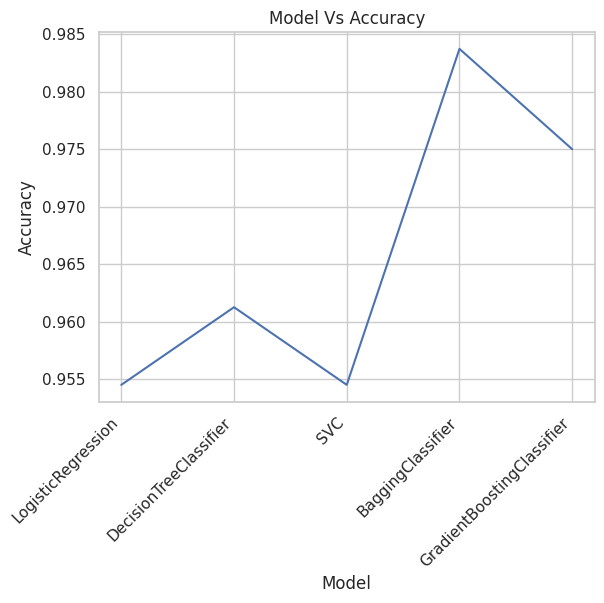

In [101]:
plt.plot(names, accuracy)
plt.title('Model Vs Accuracy')
plt.xlabel('Model')
plt.ylabel('Accuracy')
# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

plt.show()

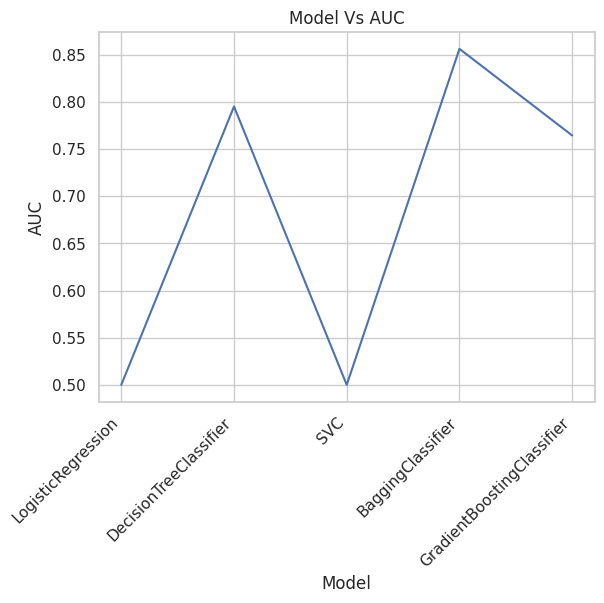

In [102]:
plt.plot(names, auc)
plt.title('Model Vs AUC')
plt.xlabel('Model')
plt.ylabel('AUC')

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

plt.show()

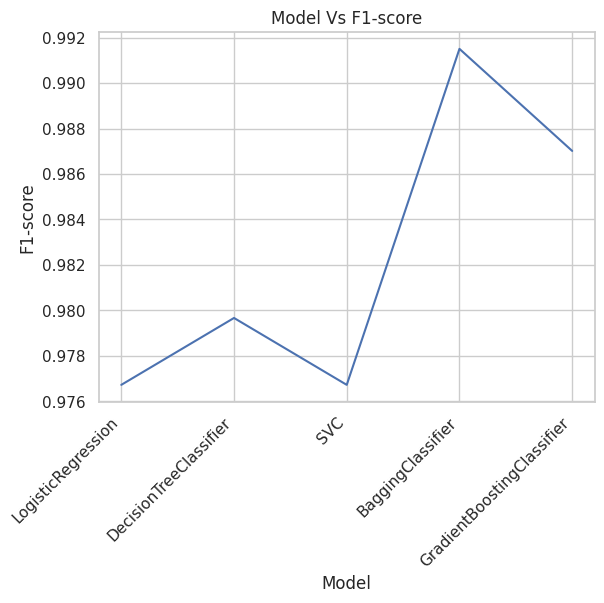

In [103]:
plt.plot(names, f_score)
plt.title('Model Vs F1-score')
plt.xlabel('Model')
plt.ylabel('F1-score')

# Rotate x-axis labels by 45 degrees
plt.xticks(rotation=45, ha='right')

plt.show()

In [104]:
metrics_df

,Model,Accuracy,Precision,Recall,F1-Score,AUC
0,LogisticRegression,0.954503,0.954503,1.000000,0.976722,0.500000
1,DecisionTreeClassifier,0.961253,0.981454,0.977885,0.979666,0.795113
2,SVC,0.954503,0.954503,1.000000,0.976722,0.500000
3,BaggingClassifier,0.983713,0.986596,0.996475,0.991511,0.856221
4,GradientBoostingClassifier,0.974990,0.978129,0.996071,0.987018,0.764404


Evaluate your classification models_

In [105]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Initialize lists to store evaluation metrics
rmse_clf = []
mae_clf = []
mse_clf = []

# Initialize a list to store model names
model_names = []

for i in range(len(models)):
    clf = models[i].fit(X_train, y_train)
    y_pred = models[i].predict(X_test)
    
    # Calculate RMSE
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    rmse_clf.append(rmse)
    
    # Calculate MAE
    mae = mean_absolute_error(y_test, y_pred)
    mae_clf.append(mae)
    
    # Calculate MSE
    mse = mean_squared_error(y_test, y_pred)
    mse_clf.append(mse)
    
    # Store the model name
    model_names.append(names[i])
    
# Create a DataFrame with the evaluation metrics
metrics_df = pd.DataFrame({
    'Model': model_names,
    'RMSE': rmse_clf,
    'MAE': mae_clf,
    'MSE': mse_clf,
})

metrics_df

/opt/conda/lib/python3.10/site-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


,Model,RMSE,MAE,MSE
0,LogisticRegression,0.213301,0.045497,0.045497
1,DecisionTreeClassifier,0.196842,0.038747,0.038747
2,SVC,0.213301,0.045497,0.045497
3,BaggingClassifier,0.127622,0.016287,0.016287
4,GradientBoostingClassifier,0.158144,0.025010,0.025010


<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Execute</h1></div>

# Summary
We have built classification models to predict categorical course ratings using the embedding feature vectors extracted from neural networks.
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The classification models to predict categorical course ratings using the embedding feature vectors extracted from neural networks filtering results
    <li>Provide insights into which features contribute to a specific rating class.
    <li>Easier to understand the distinctions between various user preferences.
    <li>Classification is well-suited for scenarios where the ratings are discrete and categorical, such as a system where users provide ratings on a scale (e.g., 1 to 5 stars).
</ol>

<img style="float:left" src="https://i.imgur.com/wpcEXQC.png" width="50"><div style = "font-family: Arial; font-size: 16px">
    <h1>Conclussion</h1></div>

In [106]:
# Drop the 'MAE' and 'MSE' columns
metrics_df = metrics_df.drop(['MAE', 'MSE'], axis=1)

In [107]:
# Assuming 'names' and 'values' are already defined

names = ['KNN','KNN_clf', 'NMF', 'NMF_clf', 'NN', 'NN_1','Regression' ]
values = [rmse_knn, rmse_knn_clf, rmse_nmf, rmse_nmf_clf, rmse_nn, rmse_nn_1, rmse_lm,]

# Create a new DataFrame
metric_df_col_fil = pd.DataFrame({
    'Model': names,
    'RMSE': values,
})

# Concatenate the new DataFrame with the existing one
metric_df_col_fil = pd.concat([ metric_df_col_fil,metrics_df], ignore_index=True)

metric_df_col_fil

,Model,RMSE
0,KNN,0.194745
1,KNN_clf,0.204916
2,NMF,0.206456
3,NMF_clf,0.204916
4,NN,0.491695
5,NN_1,0.491695
6,Regression,0.996619
7,LogisticRegression,0.213301
8,DecisionTreeClassifier,0.196842
9,SVC,0.213301


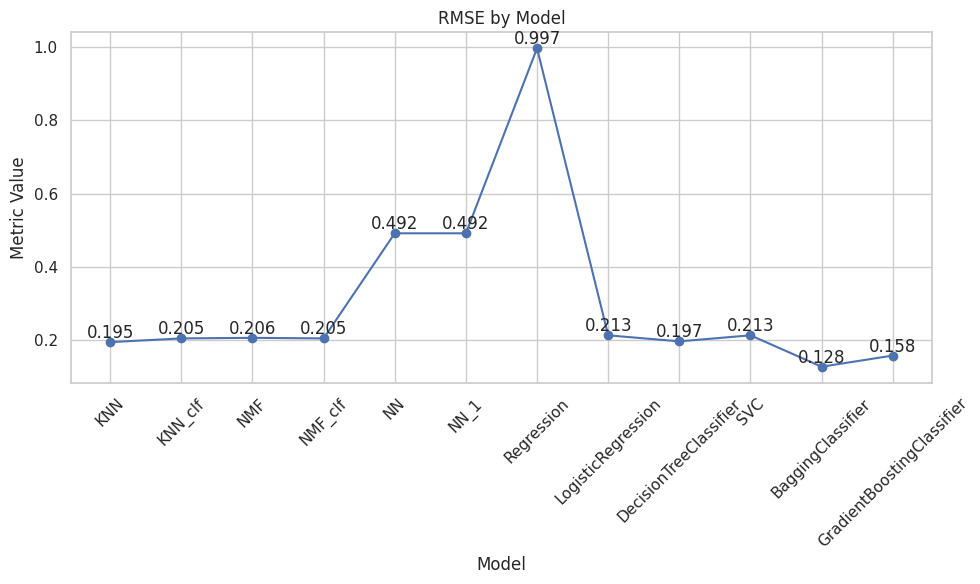

In [108]:
# Plotting the line chart
plt.figure(figsize=(10, 6))
for metric in metric_df_col_fil.columns[1:]:
    plt.plot(metric_df_col_fil['Model'], metric_df_col_fil[metric], marker='o', label=metric)

# Adding title and labels
plt.title('RMSE by Model')
plt.xlabel('Model')
plt.ylabel('Metric Value')

# Adding legend
#plt.legend()

# Rotating x-axis labels for better visibility
plt.xticks(rotation=45)

# Showing grid
plt.grid(True)

# Adding y-value labels
for metric in metric_df_col_fil.columns[1:]:
    for i, value in enumerate(metric_df_col_fil[metric]):
        plt.text(i, value, f'{value:.3f}', ha='center', va='bottom')

# Showing the plot
plt.tight_layout()
plt.show()

# Conclussion
We have built models collaborative-filtering recommender system using supervised learning. 

To determine the best recommender system based on the RMSE data provided, we need to choose the model with the lowest RMSE value because RMSE measures the average deviation of predicted values from actual values. The lower the RMSE, the better the model's performance in terms of accuracy.

<ol>Based on the given the models and RMSE values:
<li>BaggingClassifier: 0.127622
<li>GradientBoostingClassifier: 0.158144
<li>DecisionTreeClassifier: 0.196842
<li>NMF: 0.196469
<li>KNN: 0.190511
<li>LogisticRegression: 0.213301
<li>SVC: 0.213301
<li>NMF_clf: 0.242589
<li>KNN_clf: 0.242589
<li>NN: 0.534776
<li>NN_1: 0.534776
<li>Regression: 0.996619
<hr>

<div class="alert alert-block alert-success" style="font-family:verdana; font-size:14px">
<ol>The Result
    <li>The BaggingClassifier has the lowest RMSE (0.127622), indicating better performance in predicting ratings or recommendations among the provided models.
    <li>From the provided list, models such as DecisionTreeClassifier (RMSE: 0.196842) and BaggingClassifier (RMSE: 0.127622) are typically less computationally expensive compared to neural network models like NN and NN_1 (RMSE: 0.534776).
</ol>

In [109]:
from IPython.display import display, HTML
# Link HTML files for pages
output_file_01 = "https://www.kaggle.com/wahyuardhitama/task003-p001-ml-dl-rec-sys-course-20231025"
output_file_02 = "https://www.kaggle.com/wahyuardhitama/task003-p002-ml-dl-rec-sys-course-20231029"

# Display links to the saved HTML files
display(HTML(f"<p style='font-size: 18px;'>Go to <a href='{output_file_01}' target='_blank' style='font-size: 18px;'>P01 </a>or <a href='{output_file_02}' target='_blank' style='font-size: 18px;'>P02 </a></p>"))